In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [83]:
dataset = xr.open_dataset("../data/processed/cnn1d/data_10.nc")
dataset

<xarray.Dataset> Size: 220MB
Dimensions:           (samples: 670, time_steps: 2560, channels: 16)
Coordinates:
  * samples           (samples) int64 5kB 0 1 2 3 4 5 ... 665 666 667 668 669
Dimensions without coordinates: time_steps, channels
Data variables:
    signal            (samples, time_steps, channels) float64 220MB ...
    label             (samples) int64 5kB ...
    segment           (samples) int64 5kB ...
    patient_name      (samples) <U8 21kB ...
    recording_number  (samples) int64 5kB ...

In [84]:
# get sample index
df = dataset[["label", "patient_name", "samples"]].to_dataframe()
df.value_counts().sort_index()

label  patient_name
0      amer            85
       dhelal          84
       mahmud          44
       omran           64
1      bader           64
       mohammed        99
       nour            71
       saud            46
       shahad          38
       yahia           75
Name: count, dtype: int64

In [85]:
# ---- SAMPLING METHOD 1
test_patients = [
    # autism
    "bader",
    "mohammed",

    # normal
    "mahmud",
]

# split train and test persons
test_dataset = dataset.sel(
    samples=df[df["patient_name"].isin(test_patients)].index.tolist()
)
train_dataset = dataset.sel(
    samples=df[~df["patient_name"].isin(test_patients)].index.tolist()
)

# get Xy for train
X_train = train_dataset["signal"].to_numpy()
y_train = train_dataset["label"].to_numpy()

# get Xy for test
X_test = test_dataset["signal"].to_numpy()
y_test = test_dataset["label"].to_numpy()

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
## ---- SAMPLING METHOD 2
# get Xy
# X = dataset["signal"].to_numpy()
# y = dataset["label"].to_numpy()

# # stratified random sampling
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [88]:
# print statistics
print("Train:", X_train.shape, y_train.shape)
print("Classdist:", np.unique(y_train, return_counts=True))

print("Test:", X_test.shape, y_test.shape)
print("Classdist:", np.unique(y_test, return_counts=True))

Train: (463, 2560, 16) (463,)
Classdist: (array([0, 1]), array([233, 230]))
Test: (207, 2560, 16) (207,)
Classdist: (array([0, 1]), array([ 44, 163]))


## CNN 1D Classification

In [89]:
import tensorflow as tf

In [147]:
# create model

inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2],))

x = tf.keras.layers.Conv1D(64, kernel_size=128, strides=8, activation=None)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool1D(pool_size=8, strides=8)(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Conv1D(128, kernel_size=8, activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv1D(128, kernel_size=8, activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv1D(128, kernel_size=8, activation=None)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPool1D(pool_size=4, strides=4)(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)

x = tf.keras.layers.Dropout(0.5)(x)

# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.LSTM(units=32)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 2560, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 305, 64)        │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 305, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 305, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 31, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 31, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 24, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 17, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,329 (3.77 MB)

 Trainable params: 986,433 (3.76 MB)

 Non-trainable params: 896 (3.50 KB)

In [148]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    #   tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [149]:
# es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[es])
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.5113 - auc: 0.5196 - fn: 57.1000 - fp: 62.0000 - loss: 1.2716 - precision: 0.4763 - recall: 0.5094 - tn: 65.8000 - tp: 62.5000 - val_accuracy: 0.2126 - val_auc: 0.5163 - val_fn: 163.0000 - val_fp: 0.0000e+00 - val_loss: 6.8709 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 44.0000 - val_tp: 0.0000e+00
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5258 - auc: 0.5571 - fn: 60.5333 - fp: 55.2333 - loss: 0.8681 - precision: 0.5093 - recall: 0.4500 - tn: 67.6333 - tp: 64.0000 - val_accuracy: 0.2464 - val_auc: 0.6944 - val_fn: 154.0000 - val_fp: 2.0000 - val_loss: 2.2975 - val_precision: 0.8182 - val_recall: 0.0552 - val_tn: 42.0000 - val_tp: 9.0000
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5656 - auc: 0.5813 - fn: 67.6333 - fp: 44.6333 - loss: 0.7863 - precision: 0.5866 - recall: 0.3915 - tn: 82.8333 - tp: 52.3000 - val_accuracy: 0.5507 - val_auc: 0.6798 - val_fn: 

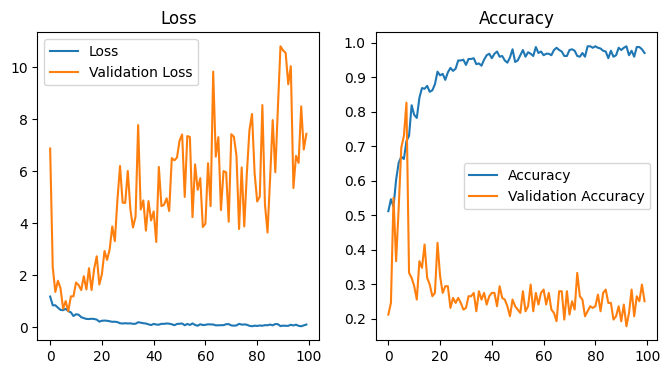

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(history.history["loss"], label="Loss")
ax[0].plot(history.history["val_loss"], label="Validation Loss")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Accuracy")
ax[1].plot(history.history["val_accuracy"], label="Validation Accuracy")
ax[1].set_title("Accuracy")
ax[1].legend()

## Evaluation

In [143]:
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [144]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2476 - auc: 0.5000 - fn: 108.3750 - fp: 0.0000e+00 - loss: 0.6992 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 27.3750 - tp: 0.0000e+00


[0.7000190615653992, 0.0, 0.0, 44.0, 163.0, 0.21256038546562195, 0.0, 0.0, 0.5]

In [145]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
MCC: 0.0
Accuracy: 0.2126
Precision: 0.0
Recall: 0.0
F1: 0.0
              precision    recall  f1-score   support

           0       0.21      1.00      0.35        44
           1       0.00      0.00      0.00       163

    accuracy                           0.21       207
   macro avg       0.11      0.50      0.18       207
weighted avg       0.05      0.21      0.07       207



/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fahmi/research/eegautism/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

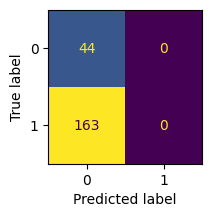

In [146]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)